For this project I want to get my Strava activity data from the API that I made and analyze the data in under 5 hours with a quick write-up. I expect that a few questions that I will be able to address will be things like the relationships between run distance  and kudos, how my running speed/run distance has been trending, and maybe some things with elevation. 

The first step will be to access my data using the API. This was the bulk of the work for this project I would say. I split it up into two requests, as requesting any more than 200 posts at a time raised an error. This would probably be nicer as one for loop, but it was a bit easier just to copy paste this. 

In [71]:
#Import everything I will need for this 
import requests
import urllib3
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import datetime as dt
from scipy.optimize import curve_fit
import scipy.stats as stats

#For future study
#from sklearn import linear_model
#from sklearn.model_selection import train_test_split

In [2]:
#Disable warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

#Urls 
auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

#Things we need for the API to give us the data
payload = {
    'client_id': "75238", 
    'client_secret': '0ad2c3b5d522ef8f4dbbb89d4759efabea4f7ff6',
    'refresh_token': '321e0aa1e8e17d37b2867e4752aa43766474cd3a',

    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

header = {'Authorization': 'Bearer ' + access_token}
param = {'per_page': 200, 'page': 1}

my_dataset1 = requests.get(activites_url, headers=header, params=param).json()
print(my_dataset1[0]["name"])

Requesting Token...

Access Token = 6bc3a4842e7d54c8dbb95ef3eb57b627658af196

Afternoon Run


In [3]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': "75238",
    'client_secret': '0ad2c3b5d522ef8f4dbbb89d4759efabea4f7ff6',
    'refresh_token': '321e0aa1e8e17d37b2867e4752aa43766474cd3a',

    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

header = {'Authorization': 'Bearer ' + access_token}

param2 = {'per_page': 200, 'page': 2}
my_dataset2 = requests.get(activites_url, headers=header, params=param2).json()
print(my_dataset2[0]["name"])

Requesting Token...

Access Token = 6bc3a4842e7d54c8dbb95ef3eb57b627658af196

Brain break because brain broke


In [4]:

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': "75238",
    'client_secret': '0ad2c3b5d522ef8f4dbbb89d4759efabea4f7ff6',
    'refresh_token': '321e0aa1e8e17d37b2867e4752aa43766474cd3a',

    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

header = {'Authorization': 'Bearer ' + access_token}
param3 = {'per_page': 200, 'page': 3}

my_dataset3 = requests.get(activites_url, headers=header, params=param3).json()
print(my_dataset3[0]["name"])

Requesting Token...

Access Token = 6bc3a4842e7d54c8dbb95ef3eb57b627658af196

Erika got stung on the boob by a bee among other things


In [51]:
#Import data wranglers 

import pandas as pd
from pandas.io.json import json_normalize

#Get json data into a dataframe so pandas can deal with it

raw1 = json_normalize(my_dataset1)
raw2 = json_normalize(my_dataset2)
raw3 = json_normalize(my_dataset3)
#Take a look at what we got
print(raw1.head(2),)
print(raw1.shape)
print(raw1.columns)

   resource_state           name  distance  moving_time  elapsed_time  \
0               2  Afternoon Run   27360.8         7681          9623   
1               2  Afternoon Run    8594.6         2922          3031   

   total_elevation_gain type  workout_type          id  \
0                 351.0  Run           0.0  6360899117   
1                  95.0  Run           0.0  6357568512   

              external_id  ...  elev_low pr_count total_photo_count  \
0  439968390300336128.fit  ...    1352.0        3                 0   
1  439952691932725249.fit  ...    1361.0        0                 0   

  has_kudoed  suffer_score athlete.id athlete.resource_state       map.id  \
0      False         191.0   24295549                      1  a6360899117   
1      False          30.0   24295549                      1  a6357568512   

                                map.summary_polyline map.resource_state  
0  gefpF|fezUKpBN`RKrAQHmCMs@L{Bi@aFFcARc@l@QhAFt...                  2  
1  _d|oFp`f

So after an initial upload of the data, we see that we get my 600 most recent uploads to strava. I'm most interested in further investigation of columns listed in the cols list below.

Also, I alter the 'start_date_local' column to make it more usable in the future. 

In [52]:
# Concatenate the dataframes and re-index
raw = pd.concat([raw1,raw2, raw3], ignore_index = True)

#These are the columns that I think will be useful
cols = ['name' , 'distance', 'moving_time', 'elapsed_time', 'total_elevation_gain', 'type', 'start_date_local', 'start_latlng', 'kudos_count', 'comment_count', 'athlete_count', 'total_photo_count', 'elev_high']

#Remove other columns
raw = raw[cols]

#Remove the non-running activities
run = raw[raw['type'] == 'Run']

#Deal with dates
import datetime as dt

#Change date column to pandas datetime 
run['start_date_local'] = pd.to_datetime(run['start_date_local'])

#Make a new hour 
run['start_hour'] = run['start_date_local'].dt.hour

#change old column to just be the date
run['start_date_local'] = run['start_date_local'].dt.date


#Check out what data looks like now and see what else needs to be changed
run.head()

,name,distance,moving_time,elapsed_time,total_elevation_gain,type,start_date_local,start_latlng,kudos_count,comment_count,athlete_count,total_photo_count,elev_high,start_hour
0,Afternoon Run,27360.8,7681,9623,351.0,Run,2021-12-08,"[39.52228160575032, -119.79902666062117]",0,0,1,0,1512.0,13
1,Afternoon Run,8594.6,2922,3031,95.0,Run,2021-12-07,"[39.4708876311779, -119.80312775820494]",1,0,2,0,1428.0,17
2,Morning Run,3262.9,983,1019,35.0,Run,2021-12-07,"[39.522215221077204, -119.79942287318408]",0,0,1,0,1387.0,9
3,Afternoon Run,10203.9,4122,4713,420.0,Run,2021-12-05,"[39.371368708088994, -119.70708447508514]",0,0,2,0,1939.0,15
4,Afternoon Run,10761.8,3513,4199,97.0,Run,2021-12-04,"[39.24743011593819, -119.97017548419535]",1,0,2,2,1938.0,15


In [53]:
#See which columns I will need to deal with
run.isnull().sum()

name                     0
distance                 0
moving_time              0
elapsed_time             0
total_elevation_gain     0
type                     0
start_date_local         0
start_latlng             0
kudos_count              0
comment_count            0
athlete_count            0
total_photo_count        0
elev_high               93
start_hour               0
dtype: int64

The 93 null values are from when I had to run in the gym due to wildfire smoke, or when I was just running in the gym/without a watch, so I'm going to fill them with the Elevation of Reno. 

In [55]:
#Fill all the zeros with elevation of Reno in meters
run['elev_high'] = run['elev_high'].fillna(1373)

#Create a new column with avg speed for the run
run['avg_speed'] = (run['distance']/1000)/(run['moving_time']/3600)



#Double check everything
run.isnull().sum()

name                    0
distance                0
moving_time             0
elapsed_time            0
total_elevation_gain    0
type                    0
start_date_local        0
start_latlng            0
kudos_count             0
comment_count           0
athlete_count           0
total_photo_count       0
elev_high               0
start_hour              0
avg_speed               0
dtype: int64

Now that the data is cleaned up, I want to take a look at the correlation matrix for the dataframe and see if anything stands out. 

<AxesSubplot:>

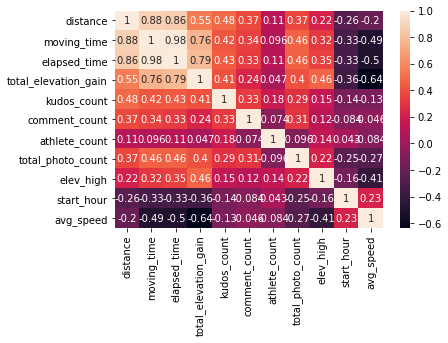

In [56]:
#Set seaborn palette to colorblind
sns.set_palette('colorblind')

#Look at the correlation matrix 
corrMat = run.corr()
sns.heatmap(corrMat, annot = True)

As we can see there isn't a whole lot that is surprisingly correlated. Longer distances tend to take more time, more vert tends to make me slower... What I do find interesting are the relationships between both number of photos and number of kudos (or likes) and other variables.

But before going on to that we should take a look at more the more standard running metrics and their relationships.  

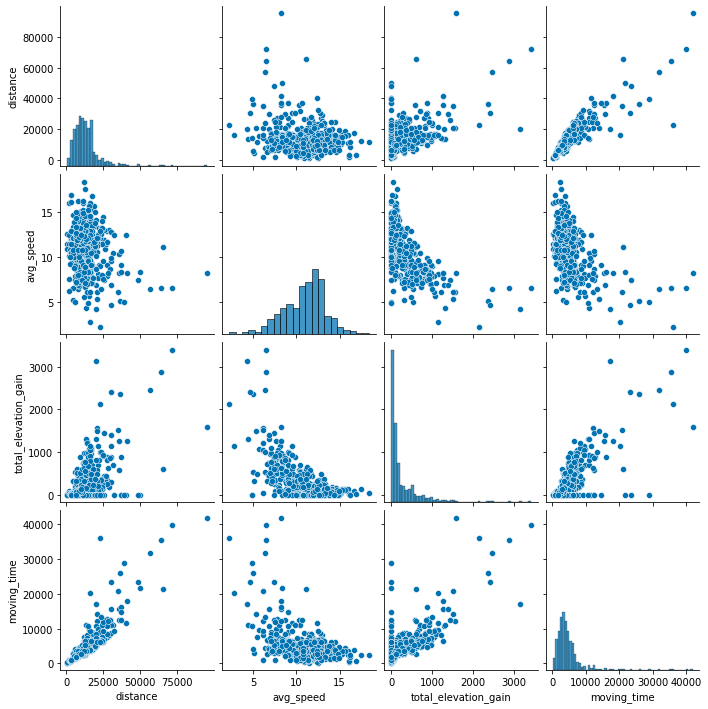

In [57]:
#Regression pair plot of the standard metrics

sns.pairplot(run[['distance', 'avg_speed', 'total_elevation_gain', 'moving_time']], kind = 'scatter')

Again we don't see aything surprising here besides the visualization of how weak the correlation between distance and average speed is for me (-.2 from the correlation matrix). If I had less data (or if I took a sample) it might be fun to fit distance vs moving time with a ploynomial. 



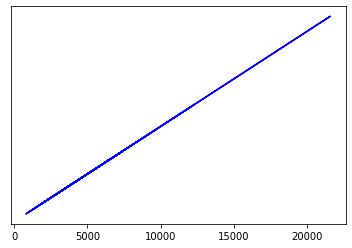

In [58]:
#We want to take a sample as curve fits can be overconstrained easily
sample = run.sample(n = 30, random_state = 1)

#Slice the samples
x_data = sample["moving_time"]
y_data = sample["distance"]

#Define an exponential
def func(x,a,b,c):
    return a * np.exp(b*x) + c 

#Use curve fit with an initial condition of [0,0,0] for [a,b,c]
popt, pcov = curve_fit(func, x_data, y_data, p0 = [0,0,0], bounds = ((0, 0, 0), (np.inf, np.inf, np.inf))) 

#Plot the fitted curve 
plt.plot(x_data, func(x_data, *popt), 'b-')
plt.yticks([])


plt.show()


Well that just looks like a line when we should be expecting some kind of exponential curve. My best guess as to why this is the case is that most of my data is near the lower end for distance and the curve fit function is using least squares which will optimize the fit to where the majority of the data is. If we restrict the data to there we can see that it is close to being linear which makes our results make sense.   

Something else that might be worth looking at is the trend for my speed over time.

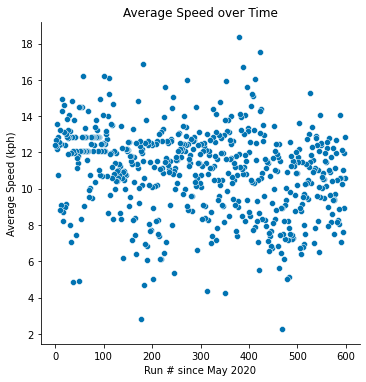

In [59]:
#Look at date vs avg speed (note we need to index it backwards to get it in increasing time order)

sns.relplot(kind = 'scatter', x = run.index[::-1], y = 'avg_speed', data = run).set(title = 'Average Speed over Time', ylabel = 'Average Speed (kph)', xlabel = 'Run # since May 2020') 


We see a slight negative relationship between the run index and the average speed. This indicates that I haven't really been running slower by all that much over time. It does seem that I have not been running as many hard runs for the past 200 runs which makes sense as I was training for an ultramarathon and simeultaneously got COVID (this may account for a large part of the negative relationship). To see about this I'll do the same thing with time and distance.  

It would be interesting to see if start time affects my speed at all...

[Text(0.5, 1.0, 'Run start time vs Average Speed'),
 Text(0.5, 0, 'Starting Hour (24hr)'),
 Text(0, 0.5, 'Average Speed (kph)')]

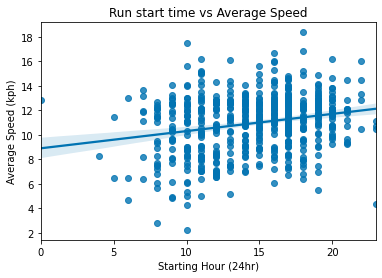

In [60]:
#Plot time vs avg speed
sns.regplot( x = 'start_hour', y = 'avg_speed', data = run).set(title = 'Run start time vs Average Speed', xlabel = 'Starting Hour (24hr)', ylabel = 'Average Speed (kph)')

It appears that the later in the day I start I am slightly more likely to run faster. This makes sense as I tend to start longer runs earlier and I run slower during those. 

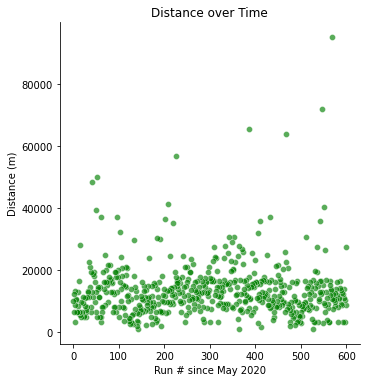

In [61]:
#Plot index (flipped) vs distance
sns.relplot(kind = 'scatter', x = run.index[::-1], y = 'distance', data = run, alpha = 0.65, color = 'g').set(title = 'Distance over Time', xlabel = 'Run # since May 2020', ylabel = 'Distance (m)')

Well that contradicted my assumption. 

Now to move on, let's do some testing on the relationship between number of photographs uploaded and average speed (moving time, so not including time to take the pictures).

[Text(0.5, 1.0, 'Photo vs Avg Speed'),
 Text(0.5, 0, '# of Photos'),
 Text(0, 0.5, 'Average Speed (kph)')]

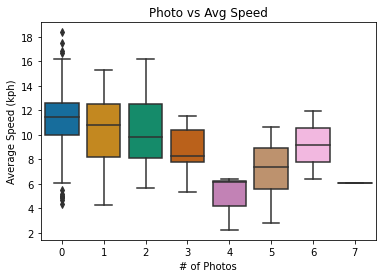

In [62]:
#Boxplot of photos vs speed
sns.boxplot(y='avg_speed', x='total_photo_count', data=run).set(title = 'Photo vs Avg Speed', xlabel = '# of Photos', ylabel = 'Average Speed (kph)')

Looks like we may be on to something here, but there might not be enough data to see what the relationship between number of photos and avg speed is.  

[Text(0.5, 1.0, 'Photo vs Avg Speed'),
 Text(0.5, 0, '# of Photos'),
 Text(0, 0.5, 'Average Speed (kph)')]

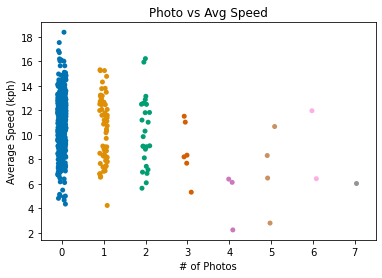

In [63]:
#Make a strip-plot to see what distributions look like, and get an idea of counts

sns.stripplot(data = run, x = 'total_photo_count', y = 'avg_speed').set(title = 'Photo vs Avg Speed', xlabel = '# of Photos', ylabel = 'Average Speed (kph)')

My suspicions are confirmed. Let's pivot to a test between photos and no photos, as that will give us the most accurate results. If we are interested in the difference between average speed between the two groups for only the last 600 runs we could just look at the population data and see if there is a difference, but if we are interested in applying the results to all of my runs we would have a problem as my data is not a random sample which is a necessary assumption for applying a t-test. Instead, I will just take a random sample of my data and see if the test agrees with the population data.  

In [64]:
#Make two new series that split the original dataframe between runs that have photos attached and those that don't
photo_0 = run['avg_speed'][run['total_photo_count'] == 0]
photo_1 = run['avg_speed'][run['total_photo_count'] >= 1]

sample_0 = photo_0.sample(n = 30, random_state = 42)
sample_1 = photo_1.sample(n = 30, random_state = 42)

#Look at the summary statistics
print(photo_0.describe())
print(photo_1.describe())
        
#t-test the two groups     
stats.ttest_ind(sample_0, sample_1)



count    489.000000
mean      11.179763
std        2.172602
min        4.360571
25%        9.990256
50%       11.458307
75%       12.584941
max       18.360312
Name: avg_speed, dtype: float64
count    105.000000
mean       9.929625
std        2.891333
min        2.253080
25%        7.689108
50%        9.853393
75%       12.070125
max       16.210476
Name: avg_speed, dtype: float64


Ttest_indResult(statistic=3.5875485370153277, pvalue=0.0006863842234515043)

So among my last 600 runs we do see a difference in mean average speed of about 1.3 km/hr. After taking a sample of 30 runs from each group I applied the t-test to see if the test returns the same result, and saw that the test estimates that there is a difference in the true mean average speed between runs with no photos and runs with them (at a 99% confidence level). 

Note that this is a 2-sided test as Jupyter Notebook is running off an older version of SciPy where there is no "alternative" keyword argument. If there were I would have done a 1-sided test, but the result would have been the same. 

But either way we reject the null hypothesis that there is no difference in the true mean average speed between runs with no photos and runs with photos. 

We probably have some confounding variables in here though like distance or location, as I am probably taking photos in locations that are pretty and people might like that more, or I am running further when I take photos and people like that. We first will deal with the distance question. To do this I will split the dataframe into four new ones which are grouped by distance run.   

In [65]:
# I want to group my runs by distance, so I will split my runs into four groups 
groups = [10000, 15000, 25000, 100000]

run_10k = pd.DataFrame()
run_15k = pd.DataFrame()
run_25k = pd.DataFrame()
run_100k = pd.DataFrame()

distances = [run_10k, run_15k, run_25k, run_100k] 


for i in range(4):
    if i == 0:
        distances[i] = run[run['distance'] <= groups[i]]
    else:
        distances[i] = run[(run['distance'] <= groups[i]) & (run['distance'] > groups[i-1])]




distances[0].head()

,name,distance,moving_time,elapsed_time,total_elevation_gain,type,start_date_local,start_latlng,kudos_count,comment_count,athlete_count,total_photo_count,elev_high,start_hour,avg_speed
1,Afternoon Run,8594.6,2922,3031,95.0,Run,2021-12-07,"[39.4708876311779, -119.80312775820494]",1,0,2,0,1428.0,17,10.588830
2,Morning Run,3262.9,983,1019,35.0,Run,2021-12-07,"[39.522215221077204, -119.79942287318408]",0,0,1,0,1387.0,9,11.949583
7,Lunch Run,3219.1,956,1070,35.0,Run,2021-12-02,"[39.52225612476468, -119.79919798672199]",1,0,1,0,1391.0,11,12.122134
9,Afternoon Run,8740.7,2975,2975,86.0,Run,2021-11-30,"[39.470813032239676, -119.80358599685133]",1,0,5,0,1424.0,17,10.576982
11,Evening Run,9100.1,3095,3241,36.0,Run,2021-11-28,"[39.52223760075867, -119.79943184182048]",1,0,2,0,1373.0,18,10.584931


Now that that is done lets plot photo count vs average speed.

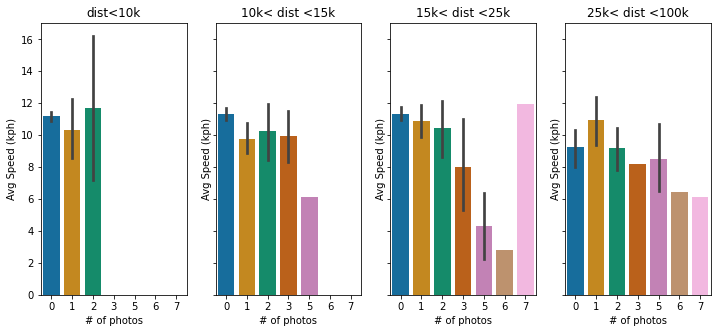

In [66]:
#Define titles for plots
titles = ['dist<10k', '10k< dist <15k', '15k< dist <25k' , '25k< dist <100k'] 

#Set up 4 side-by-side plots
fig, ax = plt.subplots(1,4, sharex = True, sharey = True, figsize = (12,5))

#Populate each plot using a for loop pulling data from the distances list in cell above
for i in range(4):
    sns.barplot(ax = ax[i], x = distances[i]['total_photo_count'], y = distances[i]['avg_speed'], data = distances[i])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('# of photos')
    ax[i].set_ylabel('Avg Speed (kph)')
    

We can see that for really short and really long runs there isn't a discernable relationship beween photos and speed. For the middle distance groups there does seem to be a negative relationship betweent the two. I think this is because for those distances I run on a mixture of trails and roads where I rarely take photos on roads and take plentiful photos on trails which tend to be slower runs. For longer runs I run almost soley on trails which are slower and the opposite for shorter runs, so we won't see a large difference in speed of those. I do find it interesting that I move at about the same speed from 0 up to 25k if I am not taking photos.  

Now, I want to do the same thing, but with kudos and photos accounting for distance. 

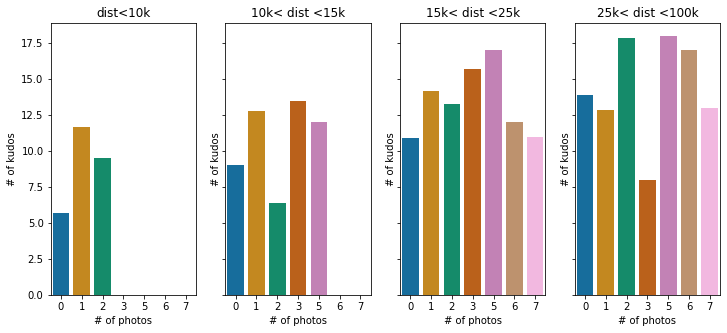

In [67]:
# Initializing 4 side-by-side plots
fig, ax = plt.subplots(1,4, sharex = True, sharey = True, figsize = (12,5))

#For loop to populate the plots with photos and kudos 
for i in range(4):
    sns.barplot(ax = ax[i], x = distances[i]['total_photo_count'], y = distances[i]['kudos_count'], data = distances[i], ci = False)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('# of photos')
    ax[i].set_ylabel('# of kudos')

It seems like if I am running up to 25k and want the most kudos that I should include a few photos. For longer runs it looks like it is hit or miss.

Looking back at the correlation matrix, we saw that distance vs kudos had a moderatly strong correlation, so lets plot a scatter plot to visualize it. 

[Text(0.5, 1.0, 'Distance vs Kudos'),
 Text(0.5, 0, 'Distance (m)'),
 Text(0, 0.5, '# of Kudos')]

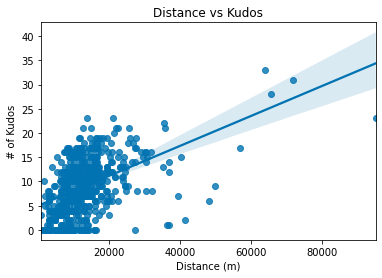

In [68]:
#Regression plot of distance vs kudos 
sns.regplot(y = 'kudos_count', x = 'distance', data = run).set(title = 'Distance vs Kudos', xlabel = 'Distance (m)', ylabel = '# of Kudos') 


We do see a relationship between kudos and distance, but with diminishing returns as the number of followers doesn't increase as I run farther.  

The last thing I would like to look at is what would happen if I got rid of the longer distances in the above plot as they seem to be pulling the regression line down by quite a bit. 

<AxesSubplot:xlabel='distance', ylabel='kudos_count'>

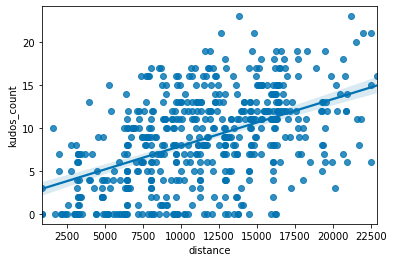

In [69]:
#Subset dataframe into runs shorter than 23k
short = run[run['distance'] < 23000]

sns.regplot(data = short, x = 'distance', y = 'kudos_count')



<AxesSubplot:>

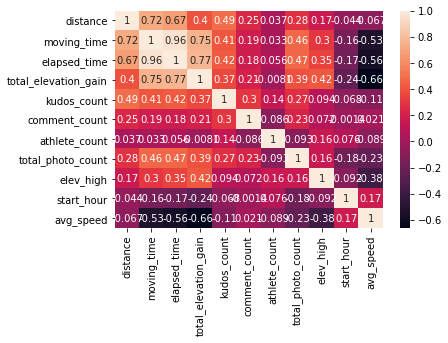

In [70]:
corrMat1 = short.corr()
sns.heatmap(corrMat1, annot = True)

It appears that after removing the longer runs, almost everything has a lower correlation. You notice a significant decrease in the correlation of elapsed time and distance which is surprising as I would have guessed that the opposite would have been true considering I stop to eat for varying amounts of times while running long, whereas when I run under 15 miles or so I don't tend to stop at all. 

In the future I would like to come back to this and maybe practice some machine learning techniques, investigate the number of people I run with and how that effects my runs, and add an animation to see where in the country I have run. 